In [2]:
import torch
from os import path
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

import h5py
import numpy as np
import wget
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim


In [3]:
classes = ('cloudy', 'rain', 'shine', 'sunrise')
data_path = 'https://raw.githubusercontent.com/Shujaat123/Weather_Classification/master/dataset/'

flist = []
for fname in classes:
    filename = f'WeatherClassificationDB_{fname}.mat'
    if not path.exists(filename):
        print(f'Downloading: {filename}')
        wget.download(data_path + filename, filename)
    else:
        print(f'{filename} already exists.')
    flist.append(filename)

# Load dataset
def load_mat_data(filename):
    with h5py.File(filename, 'r') as f:
        return np.array(f['images']['input']).astype(np.float32) / 255.0

cloudy_imgs = load_mat_data(flist[0])
rain_imgs = load_mat_data(flist[1])
shine_imgs = load_mat_data(flist[2])
sunrise_imgs = load_mat_data(flist[3])

InputImages = np.concatenate((cloudy_imgs, rain_imgs, shine_imgs, sunrise_imgs), axis=0)


WeatherClassificationDB_cloudy.mat already exists.
WeatherClassificationDB_rain.mat already exists.
WeatherClassificationDB_shine.mat already exists.
WeatherClassificationDB_sunrise.mat already exists.


In [4]:
def add_gaussian_noise(images, mean=0, stddev=0.1):
    noise = torch.normal(mean, stddev, images.shape)
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0., 1.)  # Clip values between [0,1]

# Convert to torch tensors
##InputImages = torch.tensor(InputImages).permute(0, 3, 1, 2)  # Convert to NCHW format
InputImages = torch.tensor(InputImages, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to NCHW format
noisy_imgs = add_gaussian_noise(InputImages)



print(cloudy_imgs.shape) # (NHWC)
print(rain_imgs.shape) # (NHWC)
print(shine_imgs.shape) # (NHWC)
print(sunrise_imgs.shape) # (NHWC)

InputImages.shape #Should be in NCHW now

(207, 256, 256, 3)
(215, 256, 256, 3)
(253, 256, 256, 3)
(357, 256, 256, 3)


torch.Size([1032, 3, 256, 256])

In [5]:
class WeatherDataset(Dataset):
    def __init__(self, noisy, clean):
        self.noisy = noisy
        self.clean = clean

    def __len__(self):
        return len(self.noisy)

    def __getitem__(self, idx):
        return self.noisy[idx], self.clean[idx]

# Split dataset: 70% train, 10% validation, 20% test
dataset = WeatherDataset(noisy_imgs, InputImages)
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)
test_loader = DataLoader(test_set, batch_size=16)


## Verify the train, test, and validation sample
def print_dataset_shapes(loader, name):
    data_iter = iter(loader)
    noisy_sample, clean_sample = next(data_iter)  # Get one batch
    print(f"{name} set: Noisy shape: {noisy_sample.shape}, Clean shape: {clean_sample.shape}")

# Print dataset shapes
print_dataset_shapes(train_loader, "Train")
print_dataset_shapes(val_loader, "Validation")
print_dataset_shapes(test_loader, "Test")

# Also print dataset sizes
print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")


Train set: Noisy shape: torch.Size([16, 3, 256, 256]), Clean shape: torch.Size([16, 3, 256, 256])
Validation set: Noisy shape: torch.Size([16, 3, 256, 256]), Clean shape: torch.Size([16, 3, 256, 256])
Test set: Noisy shape: torch.Size([16, 3, 256, 256]), Clean shape: torch.Size([16, 3, 256, 256])
Train set size: 722
Validation set size: 103
Test set size: 207


In [6]:
class UNet(nn.Module):
    def __init__(self, input_channels=3, Nc=64):
        super(UNet, self).__init__()

        # Contracting Path
        self.conv1 = self.conv_block(input_channels, Nc)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = self.conv_block(Nc, Nc * 2)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = self.conv_block(Nc * 2, Nc * 4)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = self.conv_block(Nc * 4, Nc * 8)
        self.pool4 = nn.MaxPool2d(2)

        self.conv5 = self.conv_block(Nc * 8, Nc * 16)

        # Expanding Path
        self.upconv6 = nn.ConvTranspose2d(Nc * 16, Nc * 8, kernel_size=2, stride=2)
        self.conv6 = self.conv_block(Nc * 16, Nc * 8)

        self.upconv7 = nn.ConvTranspose2d(Nc * 8, Nc * 4, kernel_size=2, stride=2)
        self.conv7 = self.conv_block(Nc * 8, Nc * 4)

        self.upconv8 = nn.ConvTranspose2d(Nc * 4, Nc * 2, kernel_size=2, stride=2)
        self.conv8 = self.conv_block(Nc * 4, Nc * 2)

        self.upconv9 = nn.ConvTranspose2d(Nc * 2, Nc, kernel_size=2, stride=2)
        self.conv9 = self.conv_block(Nc * 2, Nc)

        self.final_conv = nn.Conv2d(Nc, 3, kernel_size=1)
        self.final_merge_conv = nn.Conv2d(6, 3, kernel_size=1)  # Merging input and output

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

#Modification for printing intermediate outputs starts here

    def forward(self, x):
        outputs = {}


        # Contracting Path
        outputs["conv1"] = self.conv1(x)
        pool1 = self.pool1(outputs["conv1"])

        outputs["conv2"] = self.conv2(pool1)
        pool2 = self.pool2(outputs["conv2"])

        outputs["conv3"] = self.conv3(pool2)
        pool3 = self.pool3(outputs["conv3"])

        outputs["conv4"] = self.conv4(pool3)
        pool4 = self.pool4(outputs["conv4"])

        outputs["conv5"] = self.conv5(pool4)  # Bottleneck

        # Expanding Path
        up6 = self.upconv6(outputs["conv5"])
        merge6 = torch.cat((outputs["conv4"], up6), dim=1)
        outputs["conv6"] = self.conv6(merge6)

        up7 = self.upconv7(outputs["conv6"])
        merge7 = torch.cat((outputs["conv3"], up7), dim=1)
        outputs["conv7"] = self.conv7(merge7)

        up8 = self.upconv8(outputs["conv7"])
        merge8 = torch.cat((outputs["conv2"], up8), dim=1)
        outputs["conv8"] = self.conv8(merge8)

        up9 = self.upconv9(outputs["conv8"])
        merge9 = torch.cat((outputs["conv1"], up9), dim=1)
        outputs["conv9"] = self.conv9(merge9)

        outputs["final"] = self.final_conv(outputs["conv9"])

        return outputs  # Return all intermediate outputs

# Example usage
model = UNet(input_channels=3, Nc=64)

In [8]:
def psnr_metric(y_true, y_pred):
    mse = F.mse_loss(y_pred, y_true)
    return 10 * torch.log10(1 / mse)

def ssim_metric(y_true, y_pred):
    return torch.tensor(ssim(y_true.detach().cpu().numpy(), y_pred.detach().cpu().numpy(), data_range=1.0))

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.L1Loss()


In [ ]:

def train_model(model, train_loader, val_loader, epochs=100, save_path="best_model.pth"):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    

    model.to(device)  # Move model to GPU if available
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = torch.nn.MSELoss()

    best_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for noisy, clean in train_loader:
            noisy, clean = noisy.to(device), clean.to(device)  # Move data to GPU

            optimizer.zero_grad()
            outputs = model(noisy)["final"]
            loss = loss_fn(outputs, clean)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for noisy, clean in val_loader:
                noisy, clean = noisy.to(device), clean.to(device)  # Move data to GPU
                
                outputs = model(noisy)["final"]
                loss = loss_fn(outputs, clean)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Save the model if validation loss improves
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at epoch {epoch+1} with validation loss {best_loss:.4f}")

# Call the function
train_model(model, train_loader, val_loader)


In [35]:
def test_model(model, test_loader, device="cpu"):
    model.eval()
    model.to(device)
    total_psnr = 0
    total_ssim = 0
    num_samples = 0
    
    with torch.no_grad():
        for noisy, clean in test_loader:
            noisy, clean = noisy.to(device), clean.to(device)
            outputs = model(noisy)["final"]
            
            for i in range(noisy.shape[0]):
                y_true = clean[i].permute(1, 2, 0).cpu().numpy()
                y_pred = outputs[i].permute(1, 2, 0).cpu().numpy()
                
                total_psnr += psnr(y_true, y_pred, data_range=1.0)
                total_ssim += ssim(y_true, y_pred, multichannel=True, data_range=1.0, win_size=3)

                num_samples += 1
    
    avg_psnr = total_psnr / num_samples
    avg_ssim = total_ssim / num_samples
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average SSIM: {avg_ssim:.4f}")

# usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
## Check out how to load weights
model.load_state_dict(torch.load('/home/sulaimon/EXPERIMENT/Image Denoising with unet/best_model.pth', weights_only=True))
##model = EXPERIMENT/Image Denoising with unet/best_model.pth
##/home/sulaimon/EXPERIMENT/Image Denoising with unet/best_model.pth
test_model(model, test_loader, device)


Average PSNR: 31.00 dB
Average SSIM: 0.8903


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08916782..0.98750407].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04378955..1.0457385].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.025119513..0.9447773].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011048176..1.1147302].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0019567898..1.0632068].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08323211..1.0931497].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range 

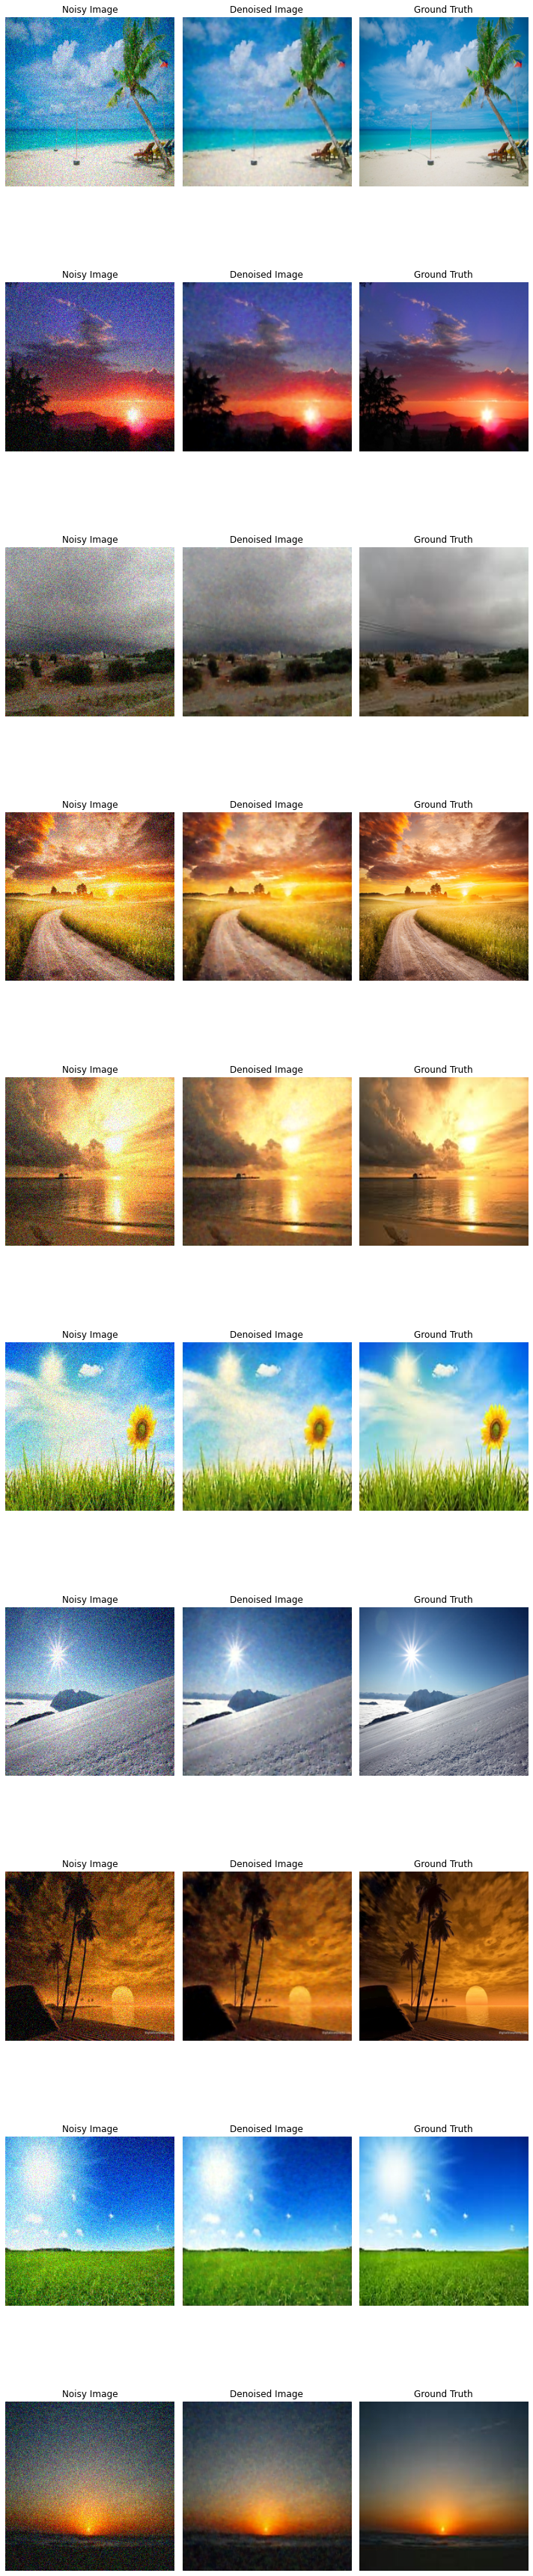

In [36]:
def visualize_results(model, test_loader, device, num_samples=10):
    model.eval()
    model.to(device)
    
    data_iter = iter(test_loader)
    noisy, clean = next(data_iter)
    noisy, clean = noisy.to(device), clean.to(device)
    
    with torch.no_grad():
        outputs = model(noisy)["final"]
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 5 * num_samples))
    
    for i in range(num_samples):
        axes[i, 0].imshow(noisy[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 0].set_title("Noisy Image")
        axes[i, 0].axis("off")
        
        axes[i, 1].imshow(outputs[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 1].set_title("Denoised Image")
        axes[i, 1].axis("off")
        
        axes[i, 2].imshow(clean[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 2].set_title("Ground Truth")
        axes[i, 2].axis("off")
    
    plt.tight_layout()
    plt.show()

# usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_results(model, test_loader, device)


In [37]:
def visualize_intermediate_outputs(model, input_image, device='cpu'):
    model.eval()
    input_image = input_image.to(device)
    input_image = input_image.unsqueeze(0)

    with torch.no_grad():
        outputs = model(input_image)

    for layer_name, activation in outputs.items():
        act = activation[0].cpu().numpy()

        act_mean = np.mean(act, axis=0)

        plt.figure(figsize=(6,6))
        plt.title(f'Activation from: {layer_name}')
        plt.imshow(act_mean, cmap="viridis")
        plt.colorbar()
        plt.axis("off")
        plt.show

In [1]:
# data_iter = iter(test_loader)
# noisy_sample, clean_sample = next(data_iter)
# sample_input = noisy_sample[1]
# visualize_intermediate_outputs(model, sample_input, device)

In [39]:
def visualize_intermediate_outputs_channels(model, input_image, device="cpu", channels_to_display=None):
    model.eval()
    input_image = input_image.to(device)
    input_image = input_image.unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_image)
    for layer_name, activation in outputs.items():
        act = activation[0].cpu().numpy()
        num_channels = act.shape[0]
        if channels_to_display is None:
            selected_channels = range(num_channels)
        else:
            selected_channels = channels_to_display
        n_channels = len(selected_channels)
        n_cols = int(np.ceil(np.sqrt(n_channels)))
        n_rows = int(np.ceil(n_channels/n_cols))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
        axes = np.array(axes).flatten()
        for i, channel in enumerate(selected_channels):
            axes[i].imshow(act[channel], cmap="viridis")
            axes[i].set_title(f"Channel {channel}")
            axes[i].axis("off")
        for j in range(i+1, len(axes)):
            axes[j].axis("off")
            plt.suptitle(f"Activation for layer: {layer_name}")
            plt.tight_layout()
            plt.show()

In [5]:
# data_iter = iter(test_loader)
# noisy_sample, clean_sample = next(data_iter)
# sample_input = noisy_sample[4]
# visualize_intermediate_outputs_channels(model, sample_input, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012140324..0.10562049].


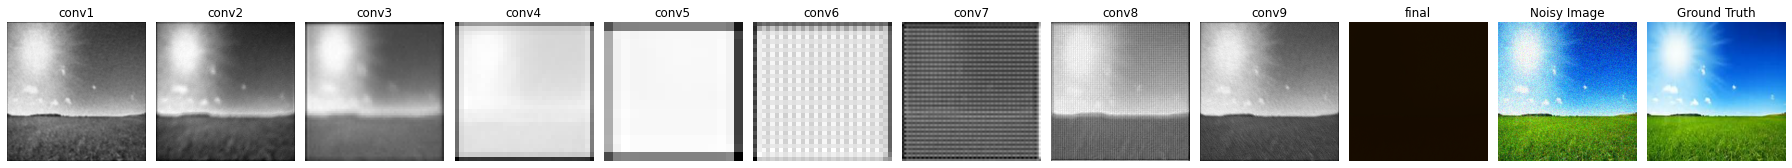

In [20]:
import torch
import matplotlib.pyplot as plt
import random

def visualize_intermediate_outputs(model, test_loader, device):
    """
    Visualizes the output images at each stage of the U-Net model for a randomly selected image.
    
    Args:
    - model: Trained U-Net model
    - test_loader: DataLoader for the test set
    - device: "cuda" or "cpu"
    """

    model.eval()
    model.to(device)

    with torch.no_grad():
        # Get a batch of images from the test set
        data_iter = iter(test_loader)
        noisy, clean = next(data_iter)
        noisy, clean = noisy.to(device), clean.to(device)

        # Pick a random image from the batch
        idx = random.randint(0, noisy.shape[0] - 1)  

        # Get outputs from all layers
        outputs = model(noisy)

        # Layers to visualize
        layers = ["conv1", "conv2", "conv3", "conv4", "conv5", "conv6", "conv7", "conv8", "conv9", "final"]

        # 🔥 Set up a single-row figure
        fig, axes = plt.subplots(1, len(layers) + 2, figsize=(25, 5))

        for j, layer in enumerate(layers):
            feature_map = outputs[layer][idx].cpu().numpy()  # Extract the randomly selected image

            # Average over channels if more than 3 channels
            if feature_map.shape[0] > 3:
                feature_map = feature_map.mean(axis=0)  # Convert to grayscale by averaging channels
            else:
                feature_map = feature_map.transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)

            # Display feature map
            axes[j].imshow(feature_map, cmap="gray")
            axes[j].set_title(f"{layer}")
            axes[j].axis("off")

        # Display noisy input (last second column)
        axes[len(layers)].imshow(noisy[idx].permute(1, 2, 0).cpu().numpy())
        axes[len(layers)].set_title("Noisy Image")
        axes[len(layers)].axis("off")

        # Display Ground Truth (last column)
        axes[len(layers) + 1].imshow(clean[idx].permute(1, 2, 0).cpu().numpy())
        axes[len(layers) + 1].set_title("Ground Truth")
        axes[len(layers) + 1].axis("off")

        plt.tight_layout()
        plt.show()

# Call the function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_intermediate_outputs(model, test_loader, device)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010744415..0.1038014].


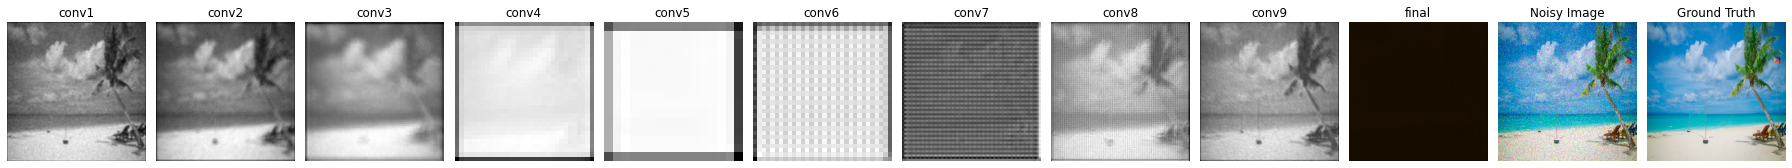

In [21]:
import torch
import matplotlib.pyplot as plt

def visualize_intermediate_outputs(model, test_loader, device):


    model.eval()
    model.to(device)

    with torch.no_grad():
        # Get a single sample from the test set
        data_iter = iter(test_loader)
        noisy, clean = next(data_iter)
        noisy, clean = noisy.to(device), clean.to(device)

        # Get outputs from all layers
        outputs = model(noisy)

        # Layers to visualize
        layers = ["conv1", "conv2", "conv3", "conv4", "conv5", "conv6", "conv7", "conv8", "conv9", "final"]

        #  Set up a single-row figure
        fig, axes = plt.subplots(1, len(layers) + 2, figsize=(25, 5))

        for j, layer in enumerate(layers):
            feature_map = outputs[layer][0].cpu().numpy()  # Extract first image in batch

            # Average over channels if more than 3 channels
            if feature_map.shape[0] > 3:
                feature_map = feature_map.mean(axis=0)  # Convert to grayscale by averaging channels
            else:
                feature_map = feature_map.transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)

            # Display feature map
            axes[j].imshow(feature_map, cmap="gray")
            axes[j].set_title(f"{layer}")
            axes[j].axis("off")

        # Display noisy input (last second column)
        axes[len(layers)].imshow(noisy[0].permute(1, 2, 0).cpu().numpy())
        axes[len(layers)].set_title("Noisy Image")
        axes[len(layers)].axis("off")

        # Display Ground Truth (last column)
        axes[len(layers) + 1].imshow(clean[0].permute(1, 2, 0).cpu().numpy())
        axes[len(layers) + 1].set_title("Ground Truth")
        axes[len(layers) + 1].axis("off")

        plt.tight_layout()
        plt.show()

# Call the function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_intermediate_outputs(model, test_loader, device)


In [ ]:
import torch
import matplotlib.pyplot as plt

def visualize_intermediate_outputs(model, test_loader, device, num_samples=3):
    """
    Visualizes the output images at each stage of the U-Net model for multiple images.

    Args:
    - model: Trained U-Net model
    - test_loader: DataLoader for the test set
    - device: "cuda" or "cpu"
    - num_samples: Number of images to display (default=3)
    """
    
    model.eval()
    model.to(device)

    with torch.no_grad():
        # Get a batch of images from the test set
        data_iter = iter(test_loader)
        noisy, clean = next(data_iter)
        noisy, clean = noisy.to(device), clean.to(device)

        # Get outputs from all layers
        outputs = model(noisy)

        # Layers to visualize
        layers = ["conv1", "conv2", "conv3", "conv4", "conv5", "conv6", "conv7", "conv8", "conv9", "final"]

        fig, axes = plt.subplots(len(layers), num_samples + 2, figsize=(15, len(layers) * 3))

        for i, layer in enumerate(layers):
            for j in range(num_samples):
                feature_map = outputs[layer][j].cpu().numpy()  # Extract j-th image in batch

                # Average over channels if more than 3 channels
                if feature_map.shape[0] > 3:
                    feature_map = feature_map.mean(axis=0)  # Convert to grayscale by averaging channels
                else:
                    feature_map = feature_map.transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)

                # Display feature map
                axes[i, j].imshow(feature_map, cmap="gray")
                axes[i, j].set_title(f"{layer} - Sample {j+1}")
                axes[i, j].axis("off")

            # Also display noisy input and ground truth for reference
            axes[i, num_samples].imshow(noisy[j].permute(1, 2, 0).cpu().numpy())
            axes[i, num_samples].set_title("Noisy Image")
            axes[i, num_samples].axis("off")

            axes[i, num_samples + 1].imshow(clean[j].permute(1, 2, 0).cpu().numpy())
            axes[i, num_samples + 1].set_title("Ground Truth")
            axes[i, num_samples + 1].axis("off")

        plt.tight_layout()
        plt.show()

# Call the function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_intermediate_outputs(model, test_loader, device, num_samples=5)
